## Build HSSM models starting from ONNX files

In this tutorial we build a `HSSM` model directly from an `onnx` file. For our purposes, the `onnx` file-format provides nice translation layer from deep learning frameworks into a common layer from which we can then reconstruct computation graph to use through **PyMC**.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import hssm

### Loading the network

In [2]:
# Networks
network_path = os.path.join("data", "race_3_no_bias_lan_no_batch.onnx")

The network we load here does not have dynamic input dimensions, which prevents us from batching computations. 

Instead of fixing things behind the scenes and loading a fixed network, 
we provide a useful snippet below that shows how to rectify this situation.

In [3]:
import onnx
import onnxruntime as ort

# Load model from path
onnx_model = onnx.load(network_path)

# Change input and output dimensions to be dynamic to allow for batching
# (in case this is not already done)
for input_tensor in onnx_model.graph.input:
    dim_proto = input_tensor.type.tensor_type.shape.dim[0]
    if not dim_proto.dim_param == "None":
        dim_proto.dim_param = "None"

for output_tensor in onnx_model.graph.output:
    dim_proto = output_tensor.type.tensor_type.shape.dim[0]
    if not dim_proto.dim_param == "None":
        dim_proto.dim_param = "None"

input_name = onnx_model.graph.input[0].name

# Please uncomment the below line to save the adjusted model
# onnx.save(onnx_model, "test_files/race_3_no_bias_lan_batch.onnx")

Armed with the corrected network, let's test inference speed on a data-batch of $1000$ trials.

In [4]:
# Load model batch ready model
ort_session = ort.InferenceSession("data/race_3_no_bias_lan_batch.onnx")

# Test inference speed
import time

start = time.time()
for i in range(100):
    ort_session.run(
        None, {input_name: np.random.uniform(size=(1000, 8)).astype(np.float32)}
    )
end = time.time()
print(f"Time taken: {(end - start) / 100} seconds")

Time taken: 0.00040030956268310546 seconds


### Defining the Likelihood

The network we loaded corresponds to a `LAN`, for a *Race* model with three choice alternatives. 
This model has three drift parameters `v0, v1, v2`, a boundary parameter `a`, a starting point bias `z` and a non-decision-time `t`.

Data from this model has the usual `rt, choice` format. 

We use this to construct a simple *blackbox likelihood* function below. This likelihood function takes the respective data and model parameters as arguments.
The function body shapes these input arguments into a matrix and performs a batched forward pass through the loaded network via the `onnx.runtime`.



In [5]:
def my_blackbox_race_model(data, v0, v1, v2, a, t, z):
    """Calculate log-likelihood for a 3-choice race model.

    Parameters
    ----------
    data : np.ndarray
        Array of shape (n_trials, 2) containing response times in first column
        and choices (0, 1, or 2) in second column
    v0 : float
        Drift rate for accumulator 0
    v1 : float
        Drift rate for accumulator 1
    v2 : float
        Drift rate for accumulator 2
    a : float
        Decision threshold/boundary
    t : float
        Non-decision time
    z : float
        Starting point bias

    Returns
    -------
    np.ndarray
        Array of log-likelihood values for each trial
    """
    data_nrows = data.shape[0]
    data = np.vstack(
        [np.full(data_nrows, param_) for param_ in [v0, v1, v2, a, t, z]]
        + [data[:, 0], data[:, 1]]
    ).T.astype(np.float32)
    return ort_session.run(None, {input_name: data})[0].squeeze()

#### Simulate example data


In [6]:
# Set parameters
v0 = 1.0
v1 = 0.5
v2 = 0.25
a = 1.5
t = 0.3
z = 0.5

# simulate some data from the model
obs_race3 = hssm.simulate_data(
    theta=dict(v0=v0, v1=v1, v2=v2, a=a, t=t, z=z), model="race_no_bias_3", size=1000
)

#### Test Likelihood Outputs

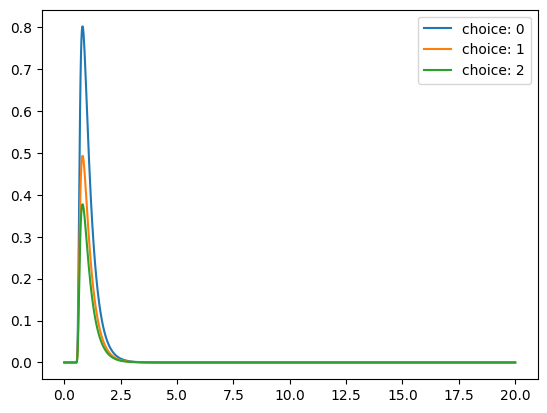

In [7]:
# Test that outputs are reasonable
for choice in [0, 1, 2]:
    rts = np.linspace(0, 20, 1000)
    choices = np.repeat(choice, 1000)

    data = np.vstack([rts, choices]).T
    out = my_blackbox_race_model(data, v0, v1, v2, a, t, z)

    plt.plot(rts, np.exp(out), label=f"choice: {choice}")
plt.legend()
plt.show()

### Build HSSM Model

We can now build a simple `HSSM` model that takes in our new blackbox likelihood.


In [8]:
model = hssm.HSSM(
    data=obs_race3,
    model="race_no_bias_3",  # some name for the model
    model_config={
        "list_params": ["v0", "v1", "v2", "a", "z", "t"],
        "bounds": {
            "v0": (0.0, 2.5),
            "v1": (0.0, 2.5),
            "v2": (0.0, 2.5),
            "a": (1.0, 3.0),
            "z": (0.0, 0.9),
            "t": (0.001, 2),
        },
    },  # minimal specification of model parameters and parameter bounds
    loglik_kind="blackbox",  # use the blackbox loglik
    loglik=my_blackbox_race_model,
    choices=[0, 1, 2],  # list the legal choice options
    z=0.5,
    p_outlier=0,
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
Model initialized successfully.


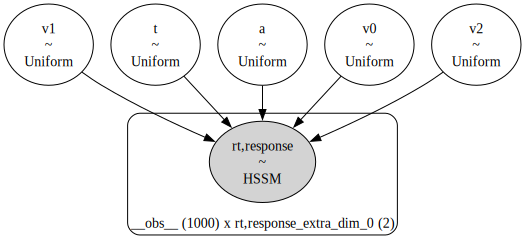

In [9]:
model.graph()

In [10]:
model.sample(draws=500, tune=200, discard_tuned_samples=False)

Using default initvals. 



Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [v1]
>Slice: [t]
>Slice: [a]
>Slice: [v2]
>Slice: [v0]


Output()

Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 2000/2000 [00:01<00:00, 1959.13it/s]


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['v0_mean'] have not been found and will be ignored
  warnings.warn(


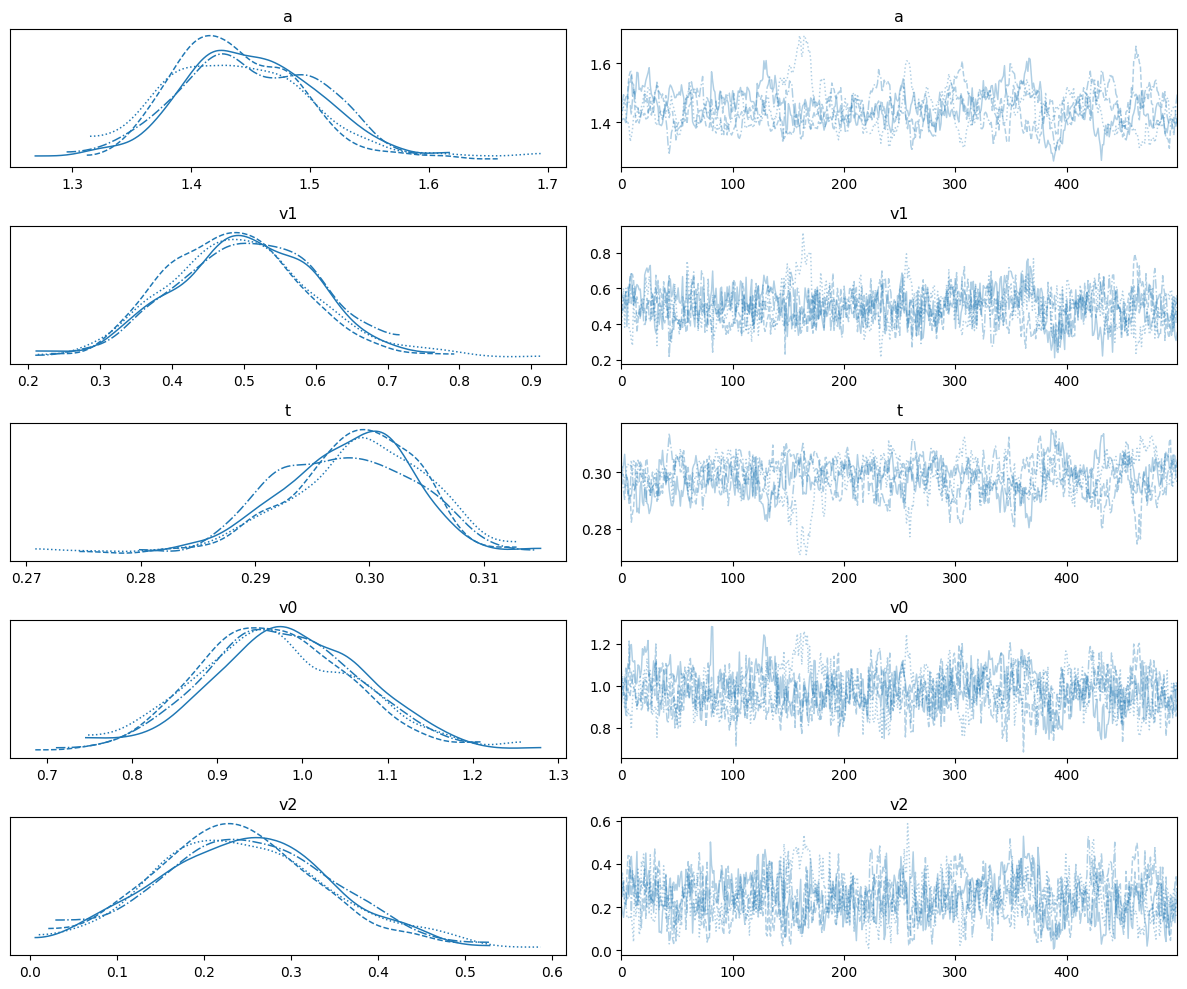

In [11]:
import arviz as az

az.plot_trace(model.traces, var_names=["~v0_mean"])
plt.tight_layout()

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['v0_mean'] have not been found and will be ignored
  warnings.warn(


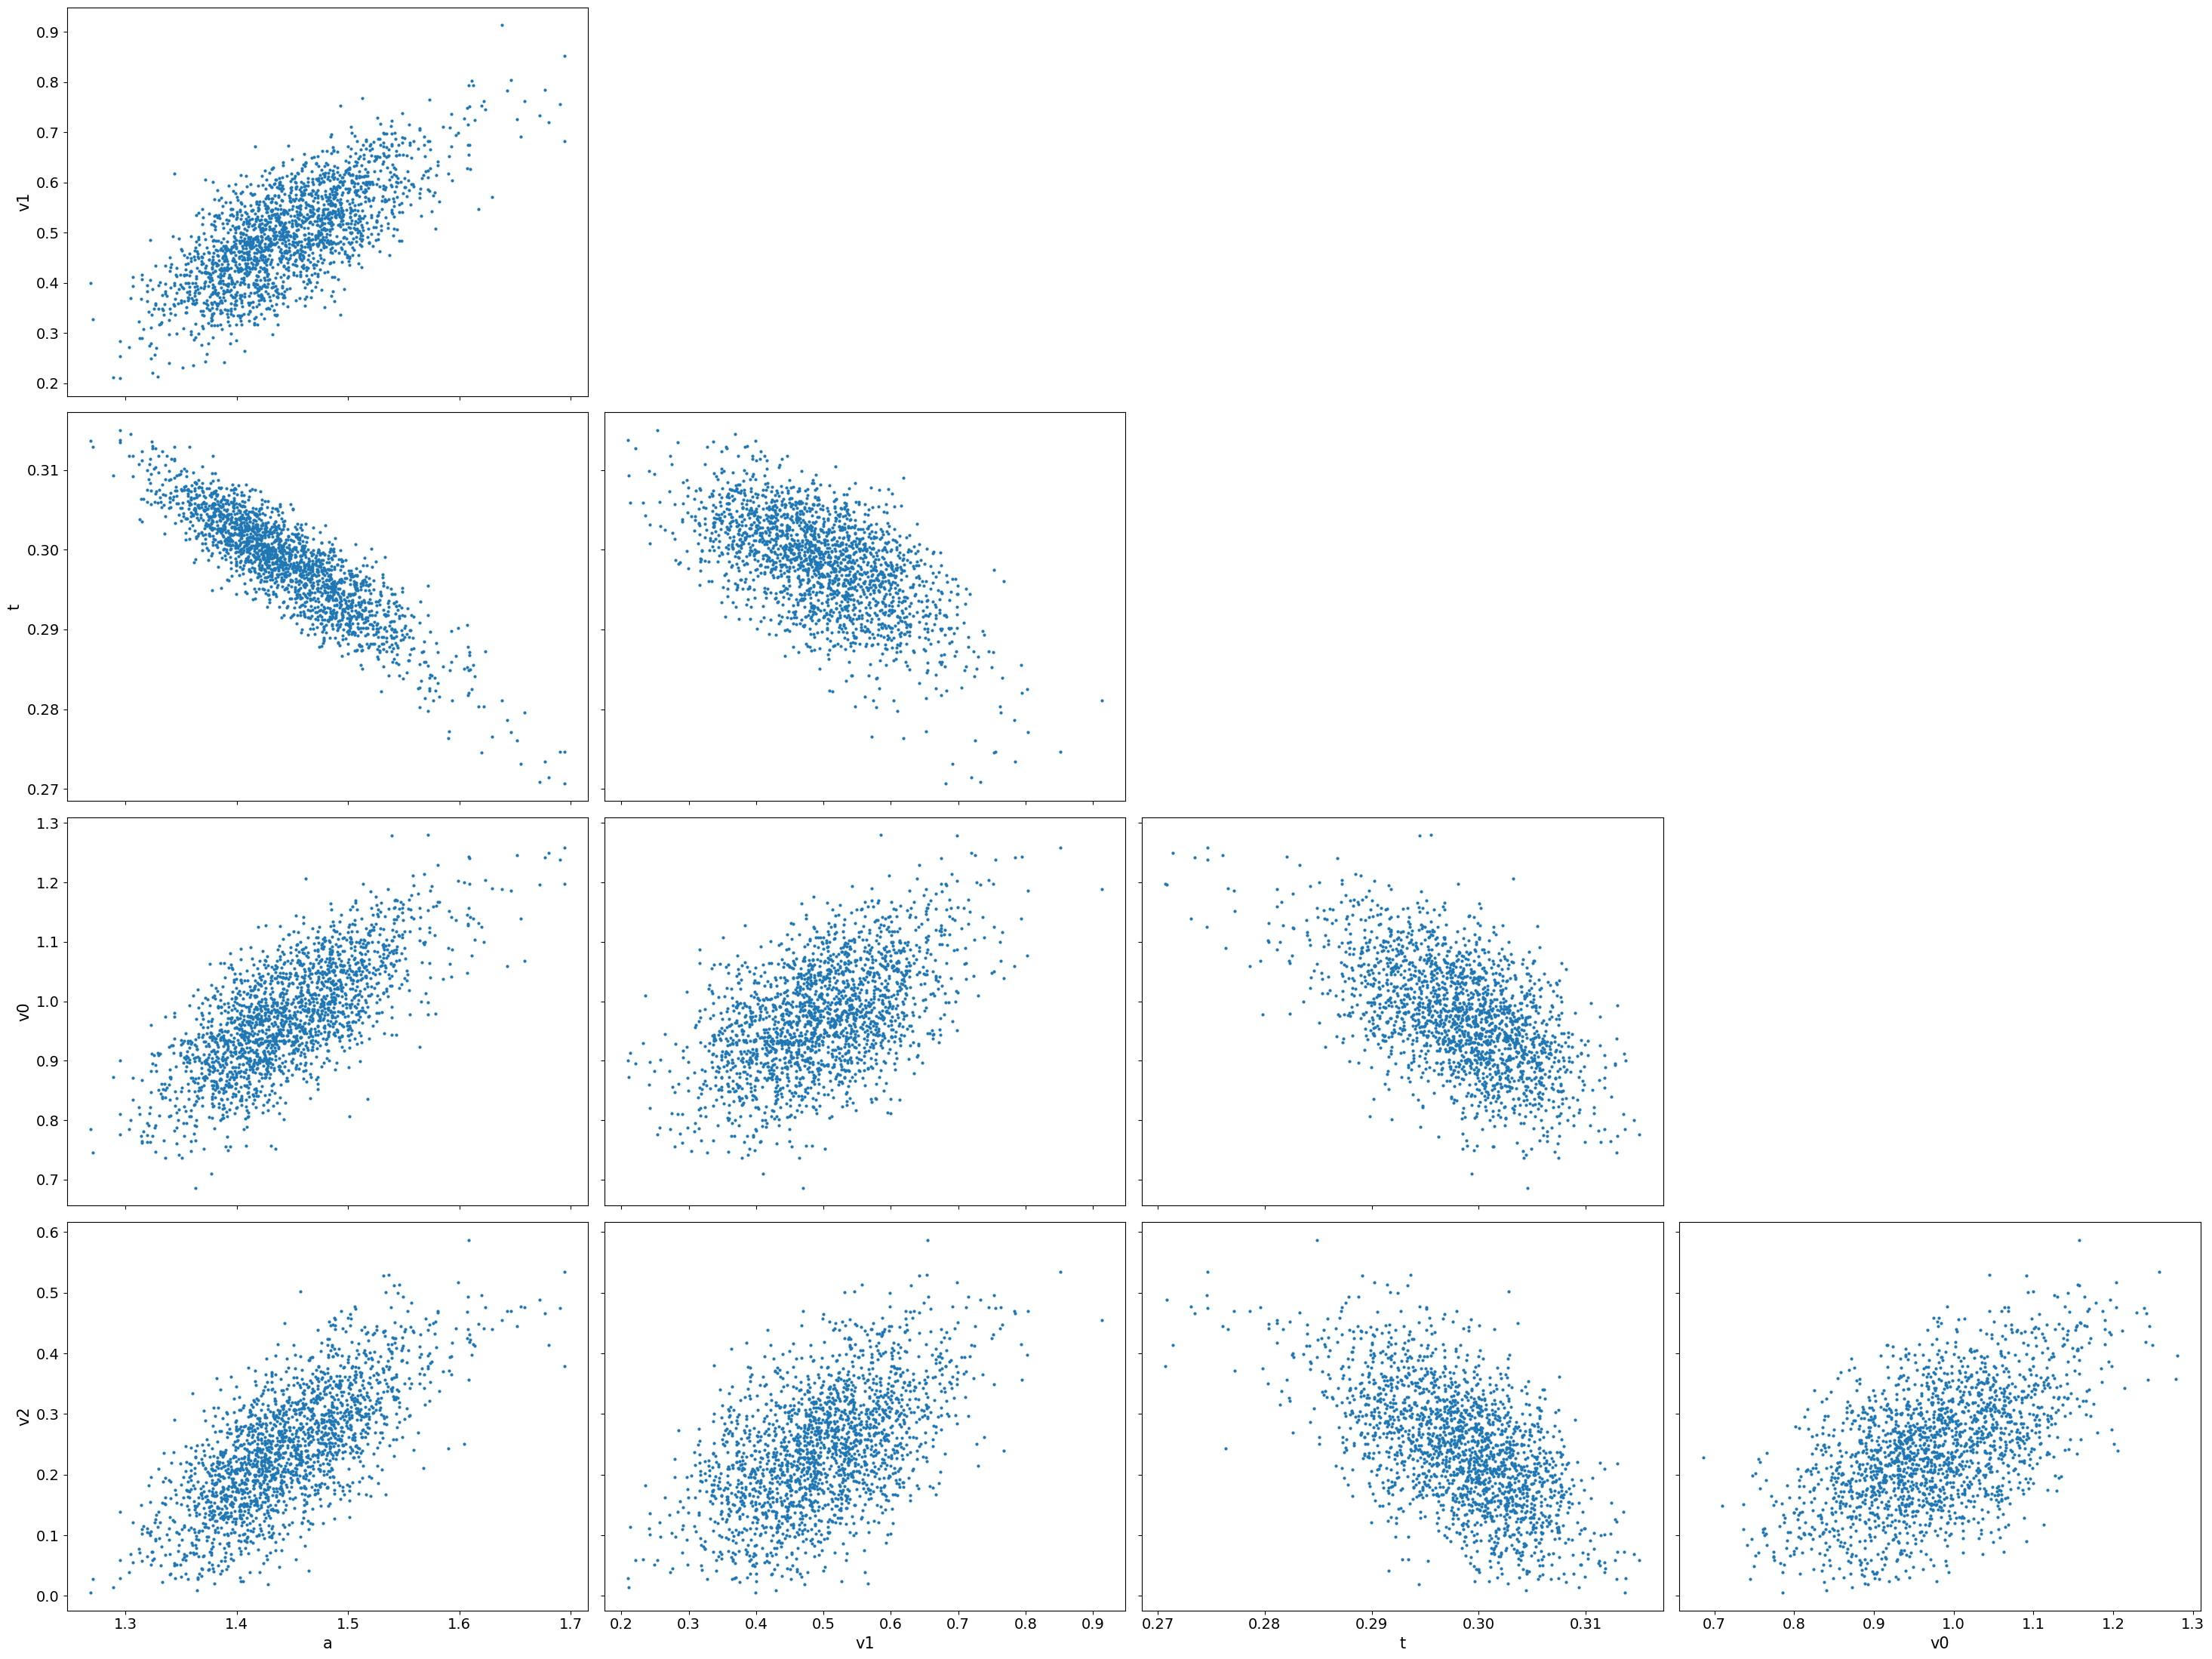

In [12]:
az.plot_pair(model.traces, var_names=["~v0_mean"])
plt.tight_layout()